# CryptoCompare: Data Collection

Getting some data from the CryptoCompare API. For understanding of the API and the extent of its functionality.

God bless [this man](https://github.com/agalea91/cryptocompare-api/blob/master/CryptoCompare.API.2017.08.ipynb) for his code.

### Some notes on CryptoCompare

They have a wide range of fantastic endpoints, which should allow for whatever kind of analysis one can put together.

- Coin List: Gives a list of all the coins they track.
- Coin Snapshot: Gives information about a coin and __all the exchanges it's on__.
- ...

## Imports

In [1]:
import uuid
import json
import datetime
import requests
import pandas as pd

# For pretty printing JSON
from IPython.display import display_javascript, display_html, display

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

### Helpers

__RenderJSON__

Prints out our JSON responses in a pleasing way.

In [2]:
class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 600px; width:100%;"></div>'.format(self.uuid), raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)

__Coin List__

Gets the list of available coins.

In [3]:
def coin_list():
    url = 'https://www.cryptocompare.com/api/data/coinlist/'
    page = requests.get(url)
    data = page.json()['Data']
    return data

## Crawlers

### Current Price

In [4]:
def price(symbol, comparison_symbols=['USD'], exchange=''):
    url = 'https://min-api.cryptocompare.com/data/price?fsym={}&tsyms={}'\
            .format(symbol.upper(), ','.join(comparison_symbols).upper())
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()
    return data

### Daily Price (Historical)

In [5]:
def daily_price_historical(symbol, comparison_symbol, limit=1, aggregate=1, exchange='', allData='true'):
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}&allData={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

### Hourly Price (Historical)

In [6]:
def hourly_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

### Hourly Price x Minute (Historical)

In [7]:
def minute_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

## Analysis

### Get some coins

In [8]:
coins = coin_list()
RenderJSON(coins)

In [9]:
len(coins)

2530

In [12]:
coins['BTC']

{'Algorithm': 'SHA256',
 'CoinName': 'Bitcoin',
 'FullName': 'Bitcoin (BTC)',
 'FullyPremined': '0',
 'Id': '1182',
 'ImageUrl': '/media/19633/btc.png',
 'Name': 'BTC',
 'PreMinedValue': 'N/A',
 'ProofType': 'PoW',
 'SortOrder': '1',
 'Sponsored': False,
 'Symbol': 'BTC',
 'TotalCoinSupply': '21000000',
 'TotalCoinsFreeFloat': 'N/A',
 'Url': '/coins/btc/overview'}

In [15]:
coins['IOT']

{'Algorithm': 'N/A',
 'CoinName': 'IOTA',
 'FullName': 'IOTA (IOT)',
 'FullyPremined': '1',
 'Id': '127356',
 'ImageUrl': '/media/1383540/iota_logo.png',
 'Name': 'IOT',
 'PreMinedValue': 'N/A',
 'ProofType': 'Tangle',
 'SortOrder': '1247',
 'Sponsored': False,
 'Symbol': 'IOT',
 'TotalCoinSupply': '2779530283',
 'TotalCoinsFreeFloat': 'N/A',
 'Url': '/coins/iot/overview'}

### Check out the current price

In [10]:
price('IOT', ['USD'], 'Bitfinex')

{'USD': 1.85}

In [11]:
price('BTC', exchange='Coinbase')

{'USD': 8509.57}

### Check out the daily price

In [22]:
df_daily = daily_price_historical('BTC', 'USD', exchange='Coinbase')

In [23]:
df_daily.head()

,close,high,low,open,time,volumefrom,volumeto,timestamp
0,370.0,370.0,300.00,300.0,1417392000,0.05656,19.53,2014-12-01
1,378.0,378.0,370.00,370.0,1417478400,15.01000,5675.07,2014-12-02
2,378.0,378.0,377.01,378.0,1417564800,0.54660,206.52,2014-12-03
3,377.1,378.0,377.10,378.0,1417651200,0.01000,3.77,2014-12-04
4,377.1,377.1,377.10,377.1,1417737600,0.00000,0.00,2014-12-05


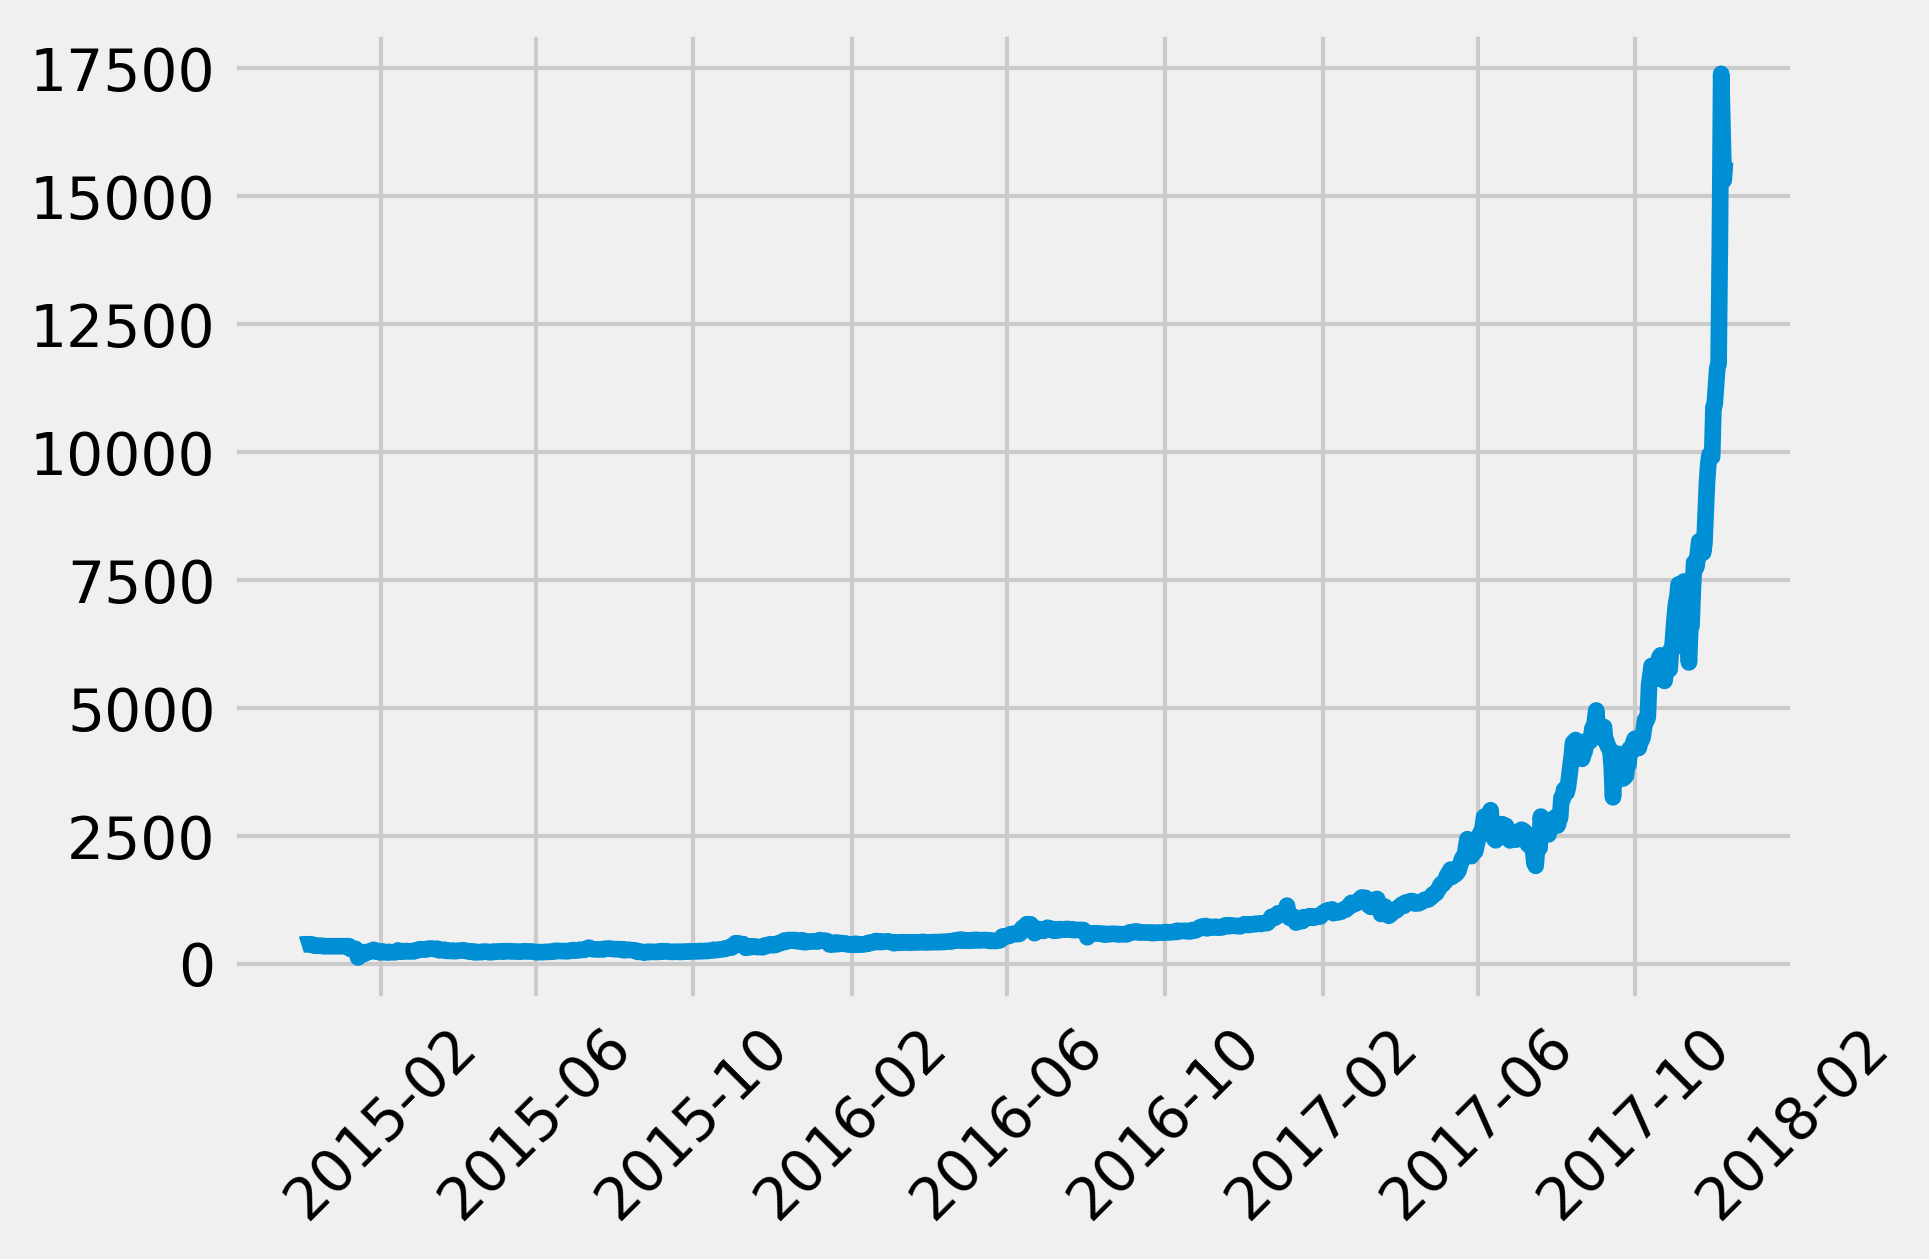

In [24]:
plt.plot(df_daily.timestamp, df_daily.close)
plt.xticks(rotation=45)
plt.show()

In [29]:
min(df_daily.timestamp)

Timestamp('2014-12-01 00:00:00')

### Let's go hourly

Max length = 2001
Max time = 83 days 07:00:00


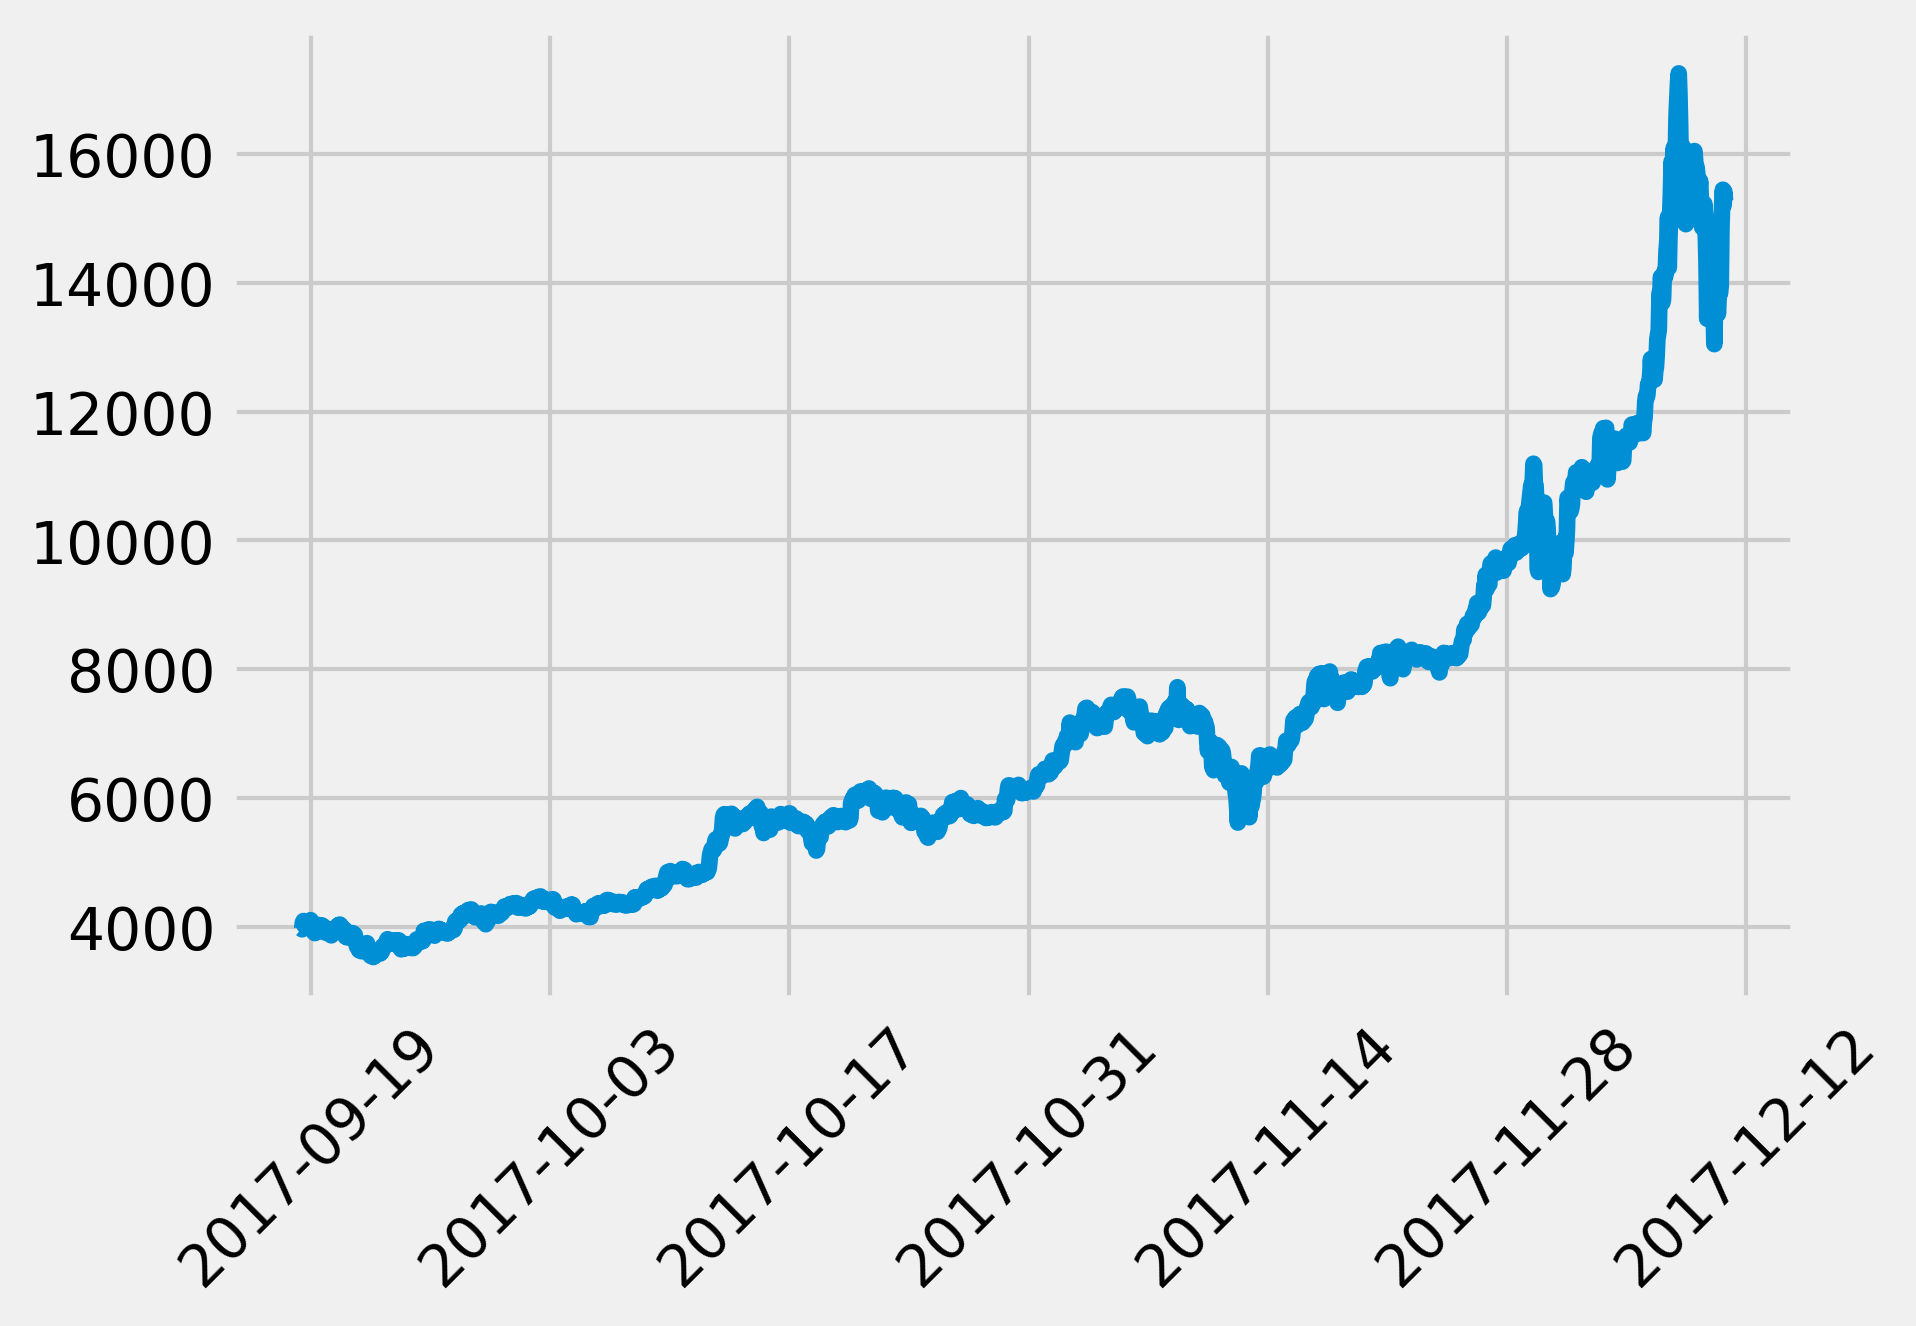

In [30]:
time_delta = 1 # Bar width in hours
df = hourly_price_historical('BTC', 'USD', 9999, time_delta)
print('Max length = %s' % len(df))
print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))

plt.plot(df.timestamp, df.close)
plt.xticks(rotation=45)
plt.show()

Max length = 84
Max time = 82 days 23:00:00


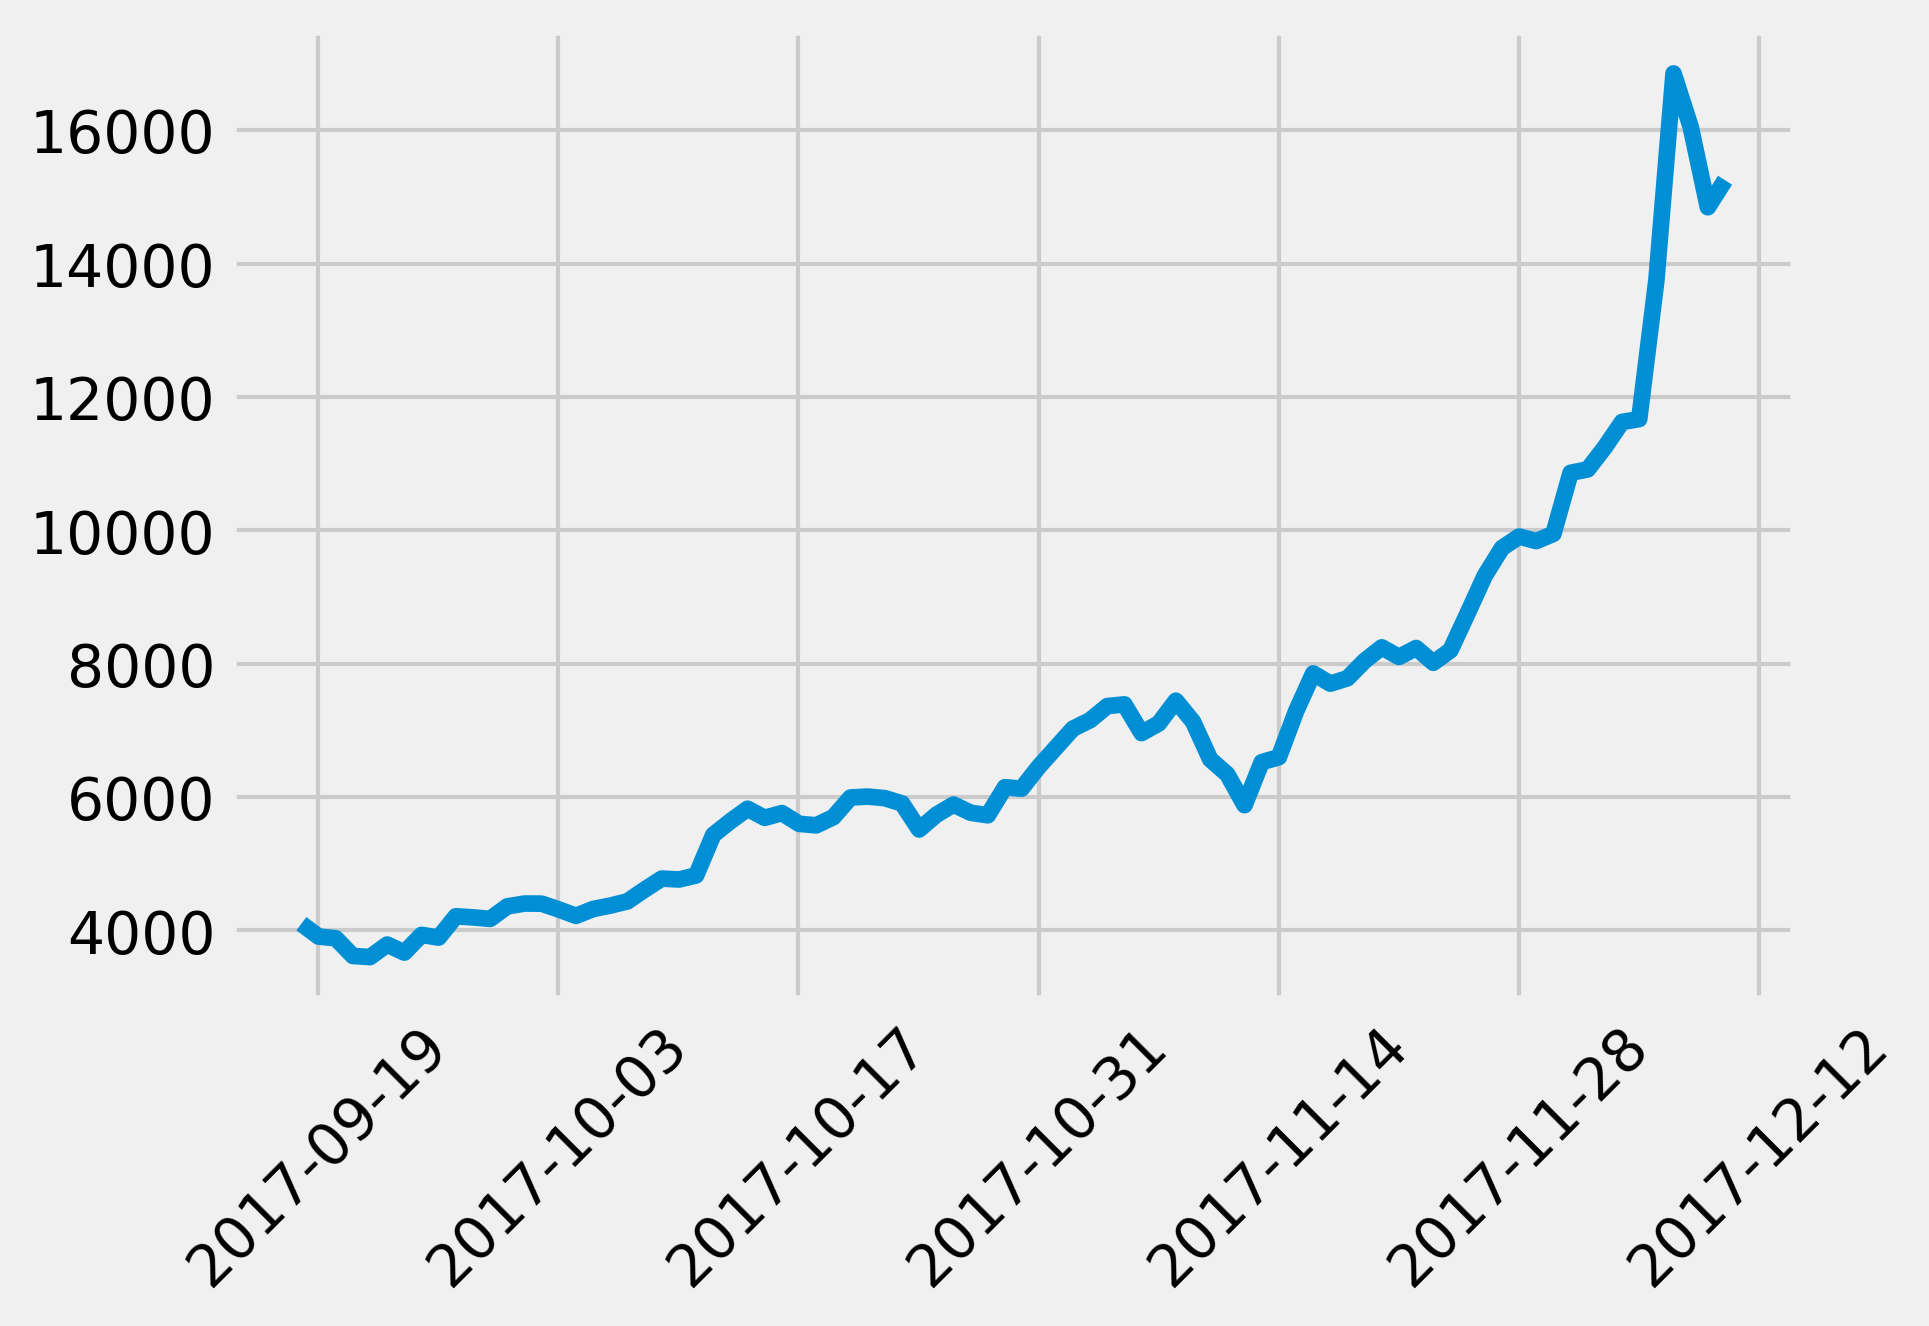

In [31]:
# Now we use hourly data to show daily pricing
time_delta = 24 # Bar width in hours
df = hourly_price_historical('BTC', 'USD', 9999, time_delta)
print('Max length = %s' % len(df))
print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))

plt.plot(df.timestamp, df.close)
plt.xticks(rotation=45)
plt.show()

### Up to the minute

Max length = 1000
Max time = 0 days 16:39:00


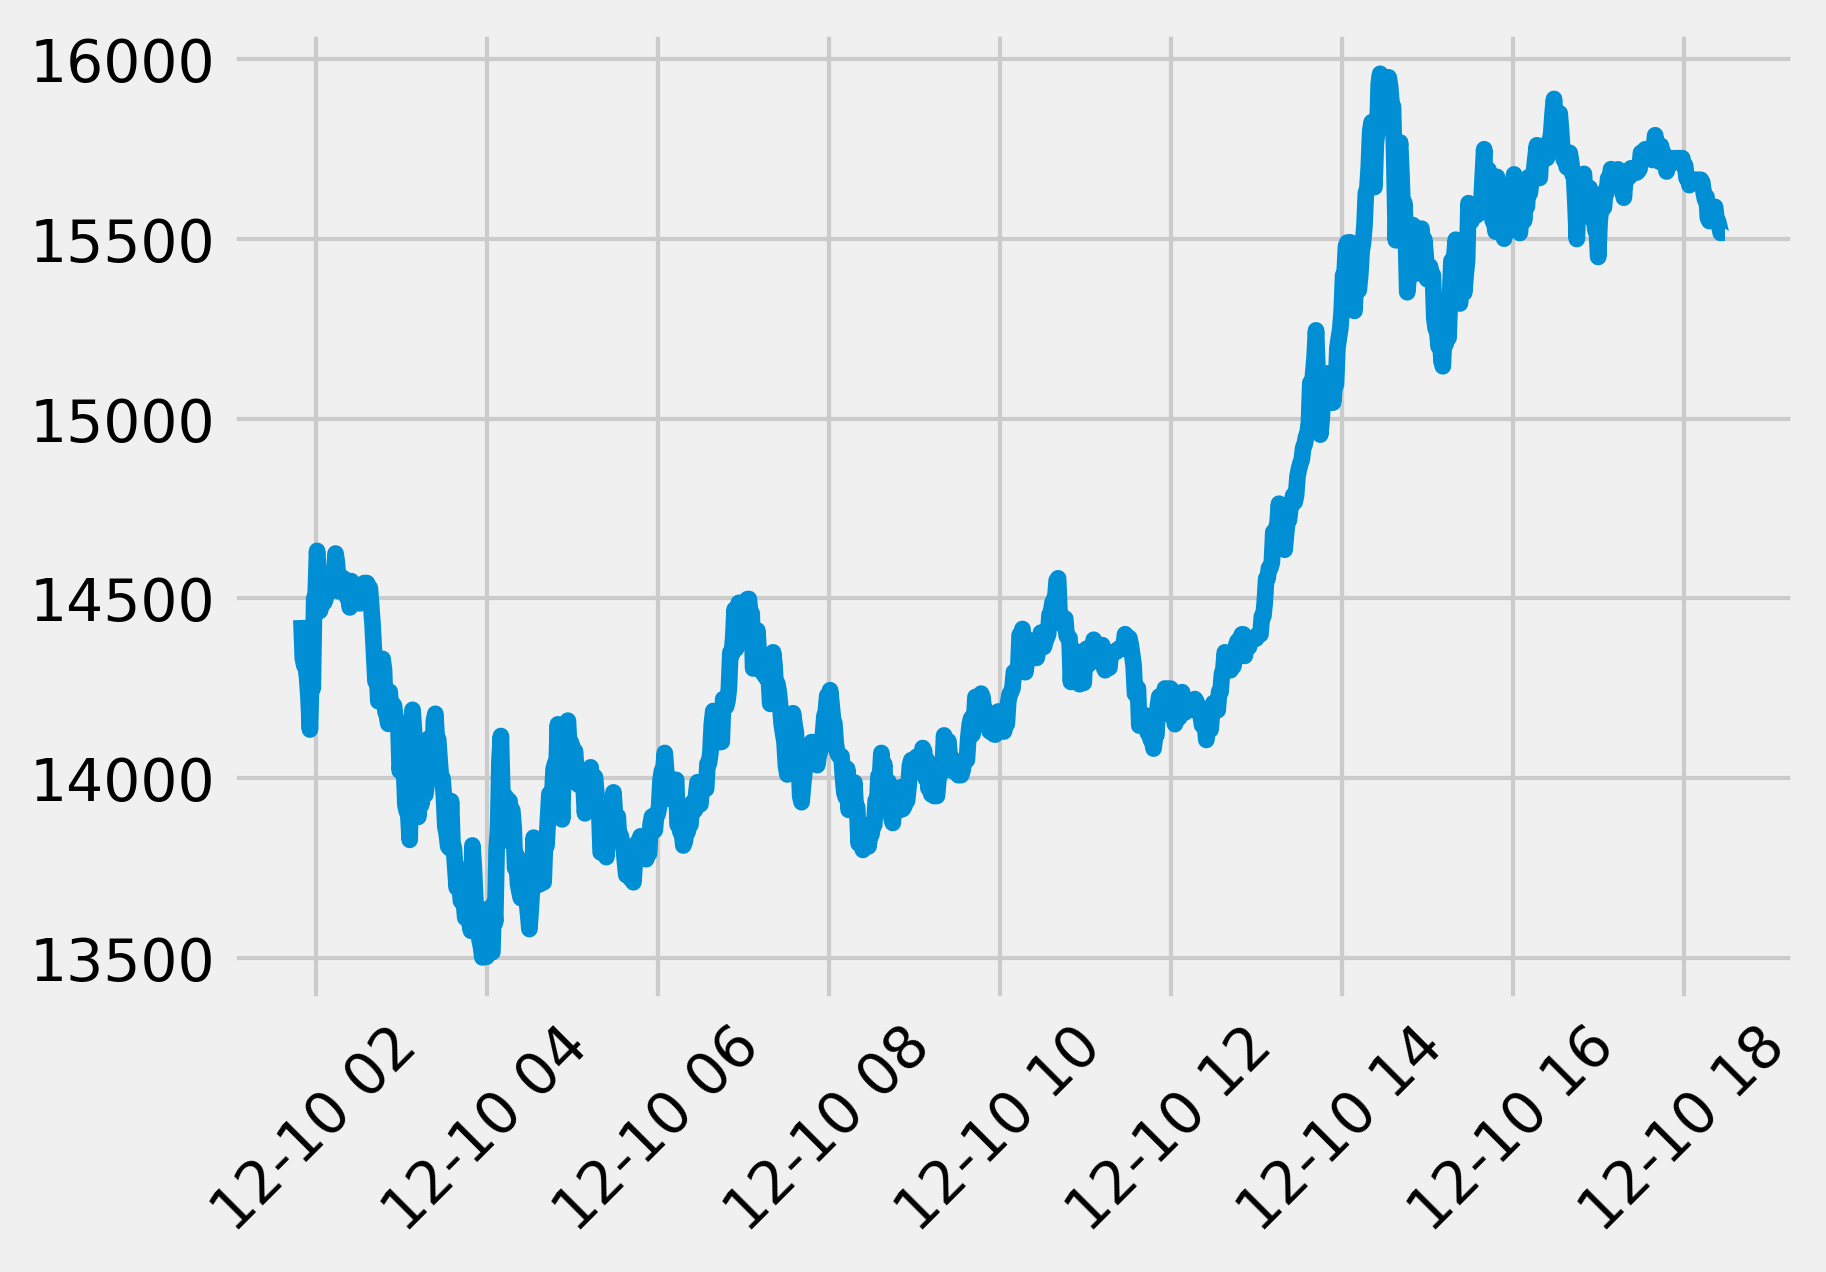

In [35]:
time_delta = 1 # Bar width in minutes
df = minute_price_historical('BTC', 'USD', 999, time_delta, exchange='Coinbase')
print('Max length = %s' % len(df))
print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))

plt.plot(df.timestamp, df.close)
plt.xticks(rotation=45)
plt.show()